<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/Main_BDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Install a newer version of matplotlib if needed
!pip install matplotlib==3.8.0

# Data processing
import pandas as pd
import numpy as np

# Train/test split and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import matplotlib.pyplot as plt

# Neural network visualization
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("completed")

# Print current directory to verify
!pwd

completed
/content


# Entity Embedding Training

Cell 2: Tải và Kiểm Tra Dataset

In [30]:
# List of columns to keep from autos.csv (adjust based on your dataset)
cols_to_keep = [
    'price',              # Target variable
    'brand',              # Categorical variable for embedding
    'model',              # Categorical variable for embedding
    'vehicleType',        # Categorical variable for embedding
    'fuelType',           # Categorical variable for embedding
    'gearbox',            # Categorical variable for dummy encoding
    'kilometer',          # Numeric variable
    'powerPS',            # Numeric variable
    'yearOfRegistration', # Numeric variable
    'monthOfRegistration',# Numeric variable
    'nrOfPictures',       # Numeric variable
    'postalCode',         # Now treated as categorical
    'dateCreated'         # To extract adYear
]

# Read data from autos.csv (adjust path as needed)
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

# Show first 5 rows
print("First 5 rows of the dataset:")
print(data.head())

# Display dataset info
print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand          dateCreated  \
0     150000                    0   benzin  volkswagen  2016-03-24 00:00:00   
1     125000                    5   diesel        audi  2016-03-24 00:00:00   
2     125000                    8   diesel        jeep  2016-03-14 00:00:00   
3     150000                    6   benzin  volkswagen  2016-03-17 00:00:00   
4      90000                    7   diesel       skoda  2016-03-31 00:00:00   

   nrOfPictures  postalCode  
0             0       70435  
1        

Cell 3: Tiền Xử Lý Dữ Liệu

In [31]:
# Extract year from dateCreated
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data = data.drop(columns=['dateCreated'])

# Define categorical and numerical columns
categorical_cols = ['brand', 'model', 'vehicleType', 'fuelType', 'postalCode', 'gearbox']
numerical_cols = ['kilometer', 'powerPS', 'yearOfRegistration', 'monthOfRegistration', 'nrOfPictures', 'adYear']

# Impute missing values: median for numeric, 'missing' for categorical
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())
for col in categorical_cols:
    data[col] = data[col].fillna('missing').astype(str)

# Cap outliers using percentiles for price and kilometer
for col in ['price', 'kilometer']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Normalize numerical data using MinMaxScaler
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Normalize price separately
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])

# Display first 5 rows after preprocessing
print("\nFirst 5 rows after preprocessing:")
print(data.head())

# Dataset info after processing
print("\nDataset info after processing:")
print(data.info())


First 5 rows after preprocessing:
      price vehicleType  yearOfRegistration    gearbox  powerPS    model  \
0  0.013333     missing            0.110346    manuell  0.00000     golf   
1  0.508333       coupe            0.112346    manuell  0.00950  missing   
2  0.272222         suv            0.111568  automatik  0.00815    grand   
3  0.041667  kleinwagen            0.111235    manuell  0.00375     golf   
4  0.100000  kleinwagen            0.112012    manuell  0.00345    fabia   

   kilometer  monthOfRegistration fuelType       brand  nrOfPictures  \
0   1.000000             0.000000   benzin  volkswagen           0.0   
1   0.827586             0.416667   diesel        audi           0.0   
2   0.827586             0.666667   diesel        jeep           0.0   
3   1.000000             0.500000   benzin  volkswagen           0.0   
4   0.586207             0.583333   diesel       skoda           0.0   

  postalCode  adYear  
0      70435     1.0  
1      66954     1.0  
2     

Cell 4: Train-Test Split and Prepare Inputs

In [38]:
# Features and target
X = data.drop(['price'], axis=1).copy()
y = data['price']

# Split into train_val and test (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train_val into train and validation (80% train, 20% validation of train_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Check number of records
print(f'\nTraining set: {X_train.shape[0]} records with {X_train.shape[1]} columns.')
print(f'Validation set: {X_val.shape[0]} records with {X_val.shape[1]} columns.')
print(f'Test set: {X_test.shape[0]} records with {X_test.shape[1]} columns.')


Training set: 237777 records with 12 columns.
Validation set: 59445 records with 12 columns.
Test set: 74306 records with 12 columns.


Cell 5: Prepare Numerical Inputs and Build Model

In [39]:
# Encode categorical variables for embedding
cat_encoders = {}
for col in categorical_cols:
    unique_cat = np.unique(X_train[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    X_train[col] = X_train[col].map(cat_encoders[col]).astype(np.int32)
    X_val[col] = X_val[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    X_test[col] = X_test[col].map(cat_encoders[col]).fillna(0).astype(np.int32)

# Prepare input lists for train, validation, and test sets
input_list_train = [X_train[col].values for col in categorical_cols] + [X_train[numerical_cols].values]
input_list_val = [X_val[col].values for col in categorical_cols] + [X_val[numerical_cols].values]
input_list_test = [X_test[col].values for col in categorical_cols] + [X_test[numerical_cols].values]

# Convert targets to float32
y_train = y_train.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)
print("completed")

complete


Cell 6: Compile and Train the Model


Model summary for the optimized EE model (v4):


Model: "Enhanced_EE_FNN_Optimized_v4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_brand (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_model (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_vehicleType         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_fuelType            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_postalCode          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gearbox             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_brand (Embedding)     │ (None, 1, 6)           │            240 │ input_brand[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_model (Embedding)     │ (None, 1, 15)          │          3,765 │ input_model[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_vehicleType           │ (None, 1, 3)           │             27 │ input_vehicleType[0][… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_fuelType (Embedding)  │ (None, 1, 2)           │             16 │ input_fuelType[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_postalCode            │ (None, 1, 50)          │        402,700 │ input_postalCode[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_gearbox (Embedding)   │ (None, 1, 1)           │              3 │ input_gearbox[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_12 (Reshape)      │ (None, 6)              │              0 │ emb_brand[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_13 (Reshape)      │ (None, 15)             │              0 │ emb_model[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 3)              │              0 │ emb_vehicleType[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_15 (Reshape)      │ (None, 2)              │              0 │ emb_fuelType[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_16 (Reshape) 

 Total params: 428,768 (1.64 MB)

 Trainable params: 428,320 (1.63 MB)

 Non-trainable params: 448 (1.75 KB)

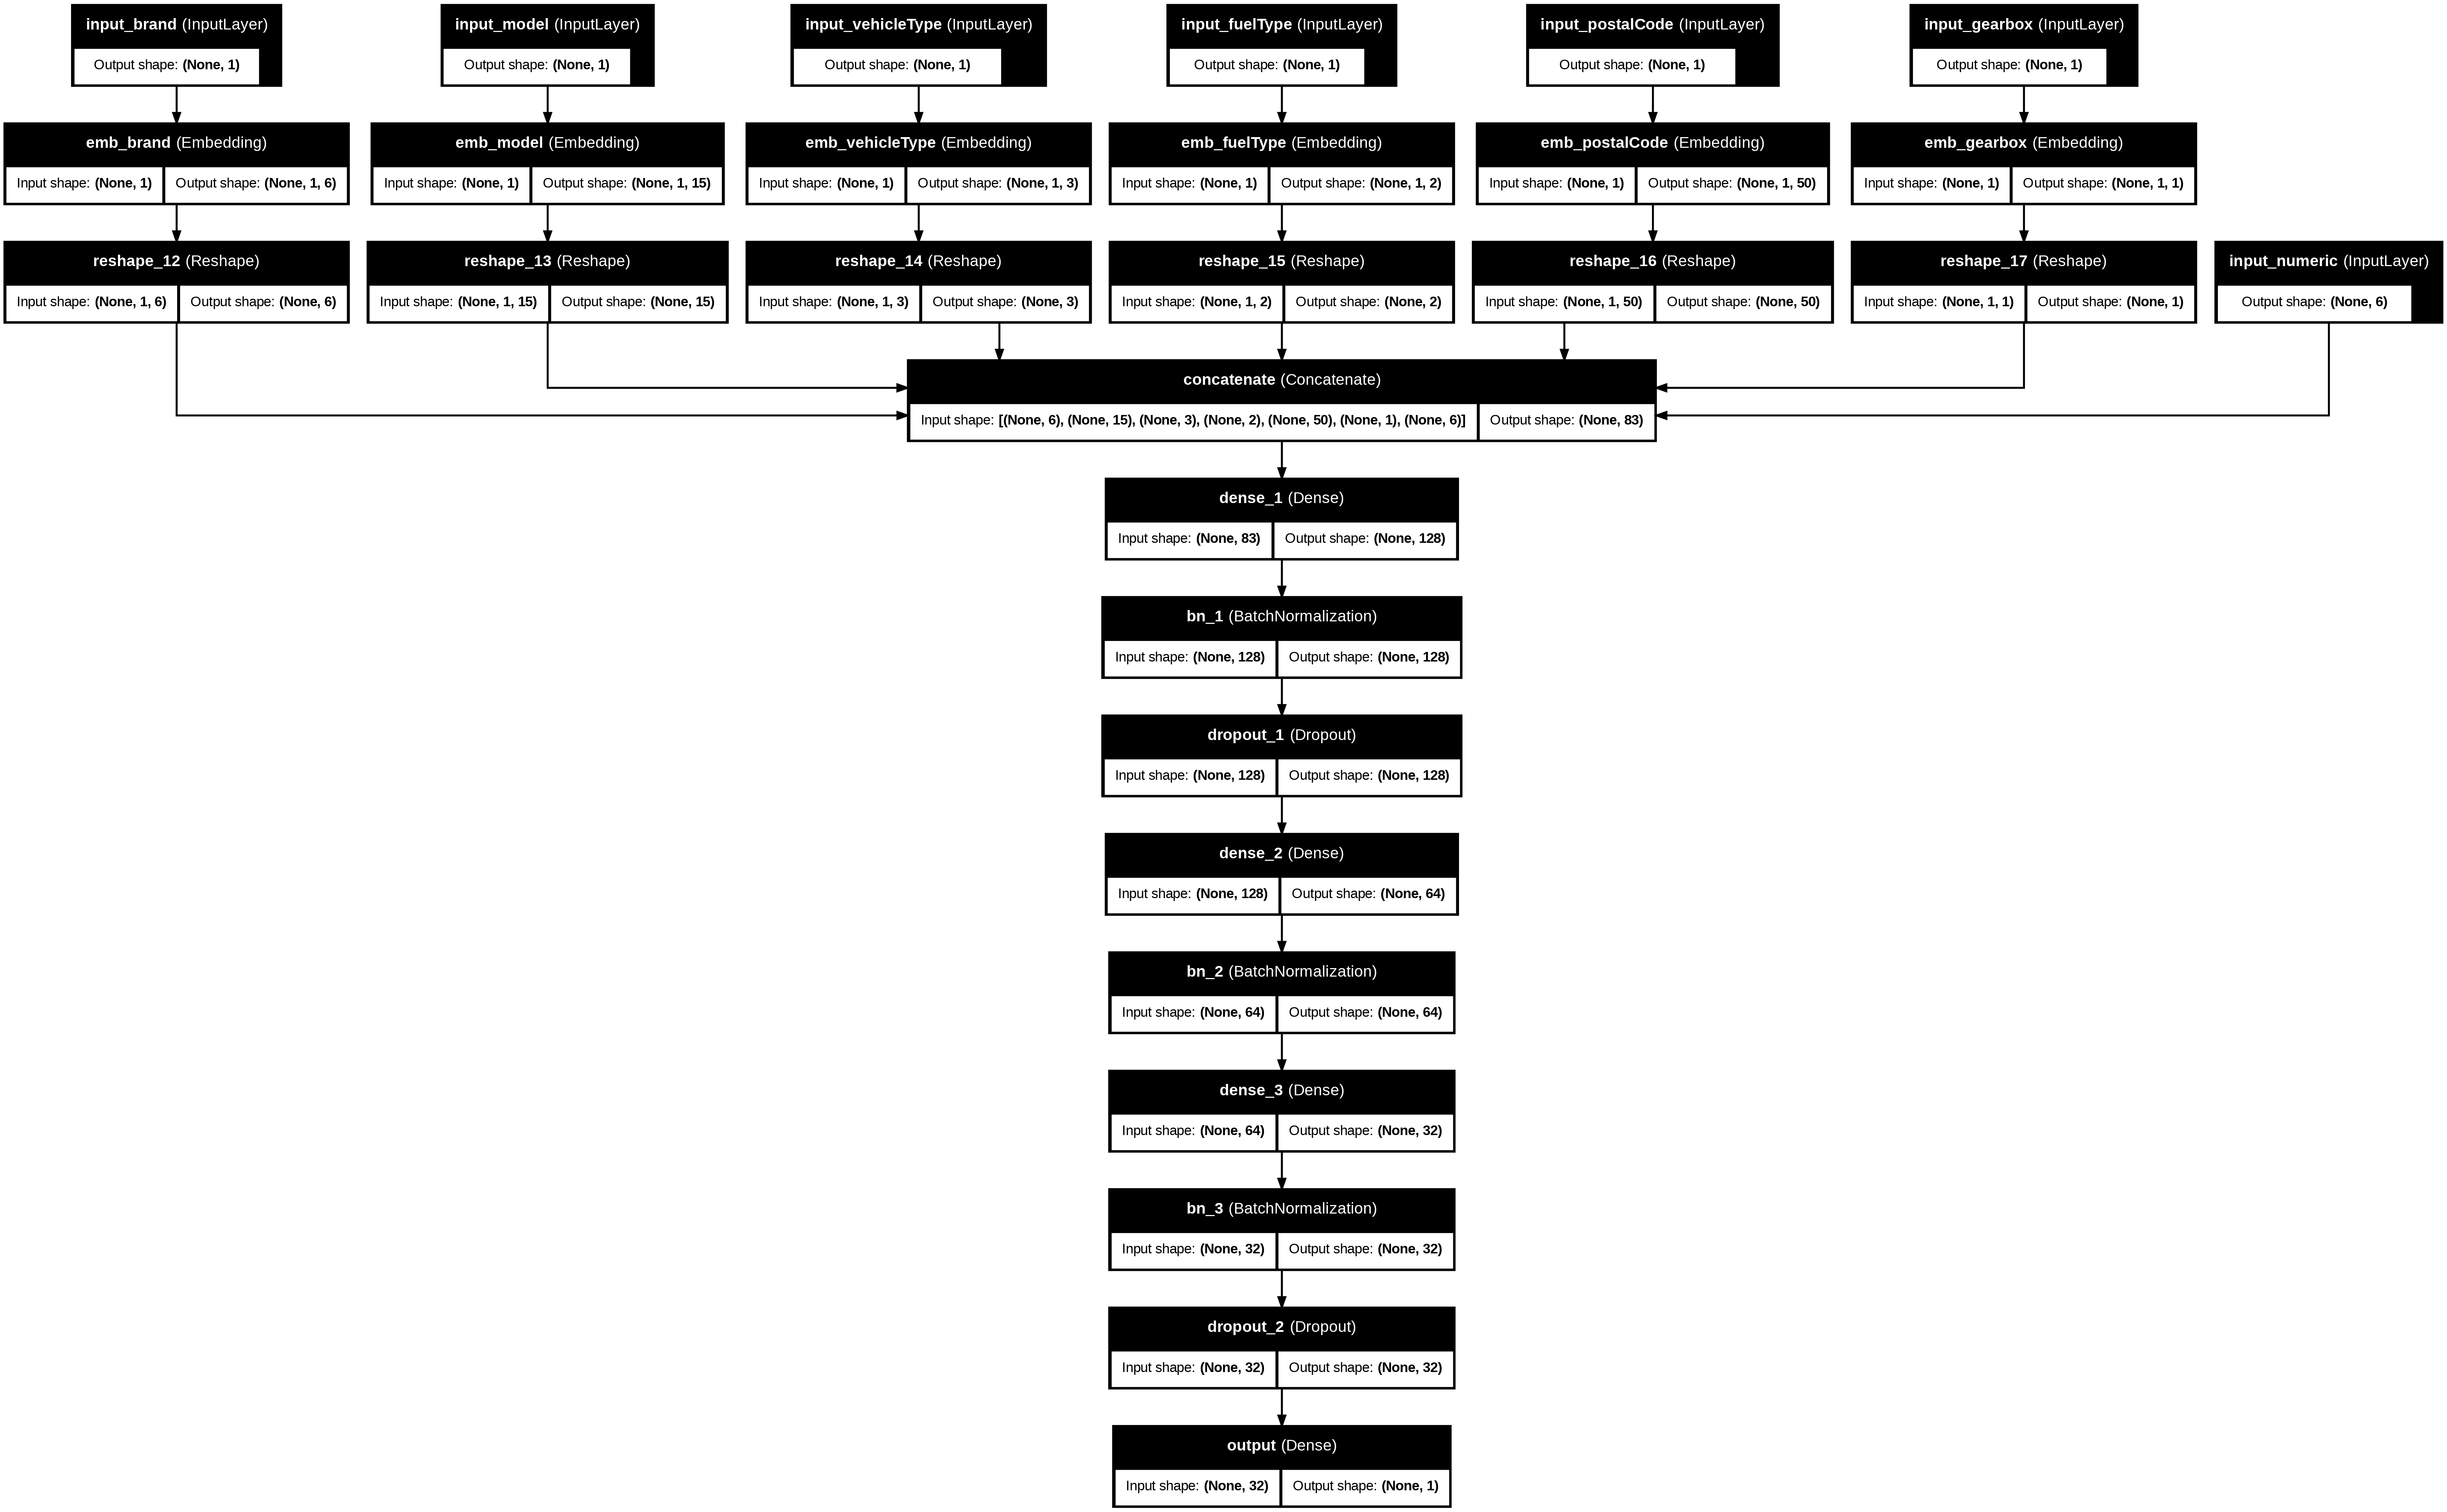

In [41]:
# Define embedding dimensions dynamically
embedding_dims = {col: min(50, int(np.sqrt(len(np.unique(X_train[col]))))) for col in categorical_cols}

# Define inputs and embedding layers for categorical variables
inputs = []
embeddings = []
for col in categorical_cols:
    input_cat = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(input_dim=len(np.unique(X_train[col])), output_dim=embedding_dims[col], name=f'emb_{col}')(input_cat)
    emb = Reshape(target_shape=(embedding_dims[col],))(emb)
    inputs.append(input_cat)
    embeddings.append(emb)

# Define input for numerical variables
input_numeric = Input(shape=(len(numerical_cols),), name='input_numeric')
inputs.append(input_numeric)

# Concatenate all embeddings and numerical input
combined = Concatenate(name='concatenate')(embeddings + [input_numeric])

# Build neural network layers with BN and L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_1')(combined)
x = BatchNormalization(name='bn_1')(x)
x = Dropout(0.2, name='dropout_1')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense_2')(x)
x = BatchNormalization(name='bn_2')(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001), name='dense_3')(x)
x = BatchNormalization(name='bn_3')(x)
x = Dropout(0.2, name='dropout_2')(x)

# Output layer (linear activation for regression)
outputs = Dense(1, activation='linear', name='output')(x)

# Create the model
nn = Model(inputs=inputs, outputs=outputs, name='Enhanced_EE_FNN_Optimized_v4')

# Model summary
print("\nModel summary for the optimized EE model (v4):")
nn.summary()

# Visualize the model architecture
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Enhanced_EE_FNN_Optimized_v4.png')
Image(retina=True, filename='Enhanced_EE_FNN_Optimized_v4.png')

Cell 7: Make Predictions and Evaluate

Epoch 1/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0064 - mae: 0.0499 - val_loss: 0.0171 - val_mae: 0.0794 - learning_rate: 1.0000e-04
Epoch 2/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0064 - mae: 0.0495 - val_loss: 0.0101 - val_mae: 0.0584 - learning_rate: 1.0000e-04
Epoch 3/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0064 - mae: 0.0498 - val_loss: 0.0096 - val_mae: 0.0581 - learning_rate: 1.0000e-04
Epoch 4/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0065 - mae: 0.0499 - val_loss: 0.0093 - val_mae: 0.0528 - learning_rate: 1.0000e-04
Epoch 5/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0064 - mae: 0.0497 - val_loss: 0.0878 - val_mae: 0.2648 - learning_rate: 1.0000e-04
Epoch 6/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0065 - mae: 0.0501 - val_loss: 0.0099 - val_mae: 0.0588 - learning_rate: 1.0000e-04
Epoch 7/300
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0065 - mae: 0.0500 - val_loss: 0.

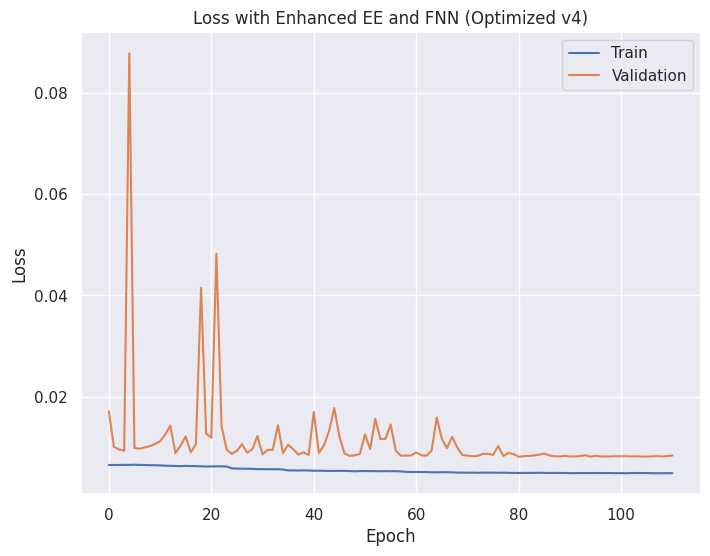

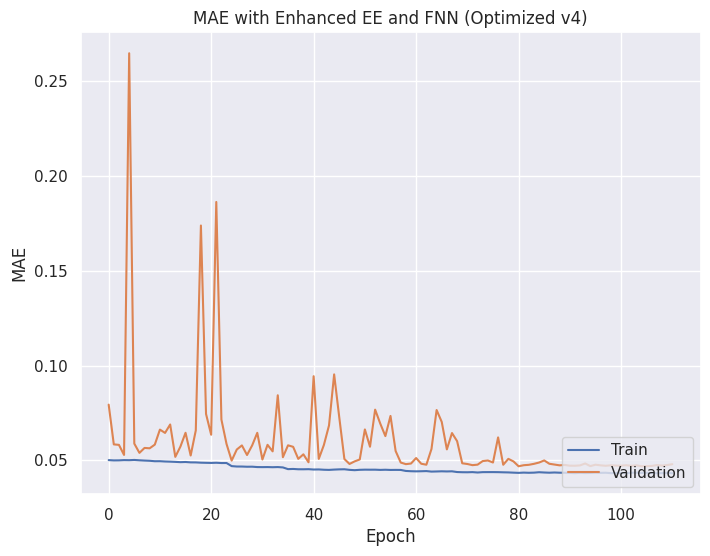

In [43]:
# Compile the model
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

# Set up early stopping with patience = 30
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

# Set up learning rate scheduler with patience = 10
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Train the model for up to 300 epochs
history = nn.fit(
    input_list_train,  # input_list_train[0]: categorical data, input_list_train[1]: numeric data
    y_train,
    validation_data=(input_list_val, y_val),
    epochs=300,
    batch_size=128,  # Có thể thử nghiệm với 256 nếu cần
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Enhanced EE and FNN (Optimized v4)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE with Enhanced EE and FNN (Optimized v4)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Cell 8: Prediction, Evaluation & Residuals Plot

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


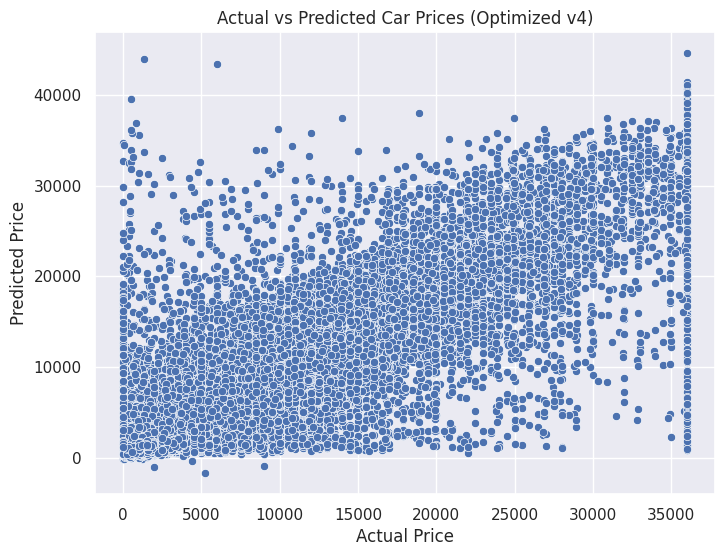

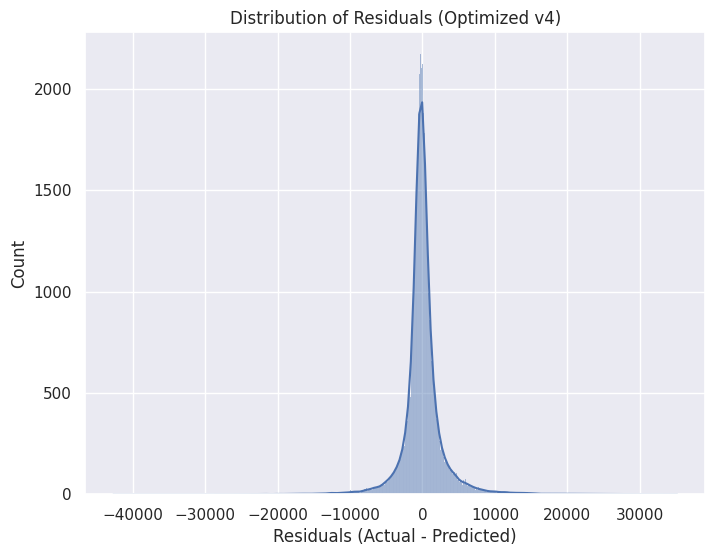


The MSE for the model is 9933311.00
The RMSE for the model is 3151.72.
The MAE for the model is 1691.16.
The R-squared for the model is 0.78.
The MAPE for the model is inf.


<ipython-input-44-c2242a8db7d2>:34: RuntimeWarning: divide by zero encountered in divide
  MAPE = np.mean(np.abs(residuals / y_test))


In [44]:
# Generate predictions on the test set
y_test_predict = nn.predict(input_list_test)

# Inverse transform predictions and true values to original scale
y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Flatten predictions if necessary
y_test_predict = y_test_predict.flatten()

# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices (Optimized v4)')
plt.show()

# Calculate residuals
residuals = y_test - y_test_predict

# Plot histogram of residuals with KDE
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Distribution of Residuals (Optimized v4)')
plt.show()

# Compute evaluation metrics
MSE = np.mean(residuals**2)
RMSE = np.sqrt(MSE)
MAE_val = np.mean(np.abs(residuals))
R2 = 1 - np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2)
MAPE = np.mean(np.abs(residuals / y_test))

print(f'\nThe MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE_val:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')

Cell9: Baseline Random Forest Model

In [ ]:
# Feature list for baseline model (excluding brand)
base_cols = [col for col in X_train.columns if col != 'brand']

# Initiate the model
base_rf = RandomForestRegressor()

# Fit the model
base_rf.fit(X_train[base_cols], y_train)

# Make predictions
base_y_test_prediction = base_rf.predict(X_test[base_cols])

# Visualization
ax = sns.scatterplot(x=y_test, y=base_y_test_prediction)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price (Baseline RF)')
plt.title('Actual vs Predicted Car Prices (Baseline RF)')
plt.show()

# Prediction error
base_model_error = y_test - base_y_test_prediction

# Mean squared error
MSE = np.mean(base_model_error**2)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = np.mean(abs(base_model_error))
# R squared
R2 = 1 - sum(base_model_error**2) / sum((y_test - np.mean(y_test))**2)
# Mean absolute percentage error
MAPE = np.mean(abs(base_model_error / y_test))

print(f'\nThe MSE for the baseline RF model is {MSE:.2f}')
print(f'The RMSE for the baseline RF model is {RMSE:.2f}.')
print(f'The MAE for the baseline RF model is {MAE:.2f}.')
print(f'The R-squared for the baseline RF model is {R2:.2f}.')
print(f'The MAPE for the baseline RF model is {MAPE:.2f}.')

Cell 10: Use Categorical Entity Embedding in Random Forest Model

In [ ]:
# Append categorical embeddings to the training dataset
X_train_emb = pd.merge(X_train, cat_emb_df, left_on='brand', right_on='cat', how='inner').drop(['brand', 'cat', 'cat_index'], axis=1)

# Append categorical embeddings to the testing dataset
X_test_emb = pd.merge(X_test, cat_emb_df, left_on='brand', right_on='cat', how='inner').drop(['brand', 'cat', 'cat_index'], axis=1)

# Check info for the training dataset
print("\nThông tin tập huấn luyện sau khi thêm embeddings:")
print(X_train_emb.info())

# Check info for the testing dataset
print("\nThông tin tập kiểm tra sau khi thêm embeddings:")
print(X_test_emb.info())

# Initiate the model
emb_rf = RandomForestRegressor()

# Fit the model
emb_rf.fit(X_train_emb, y_train)

# Make predictions
emb_y_test_prediction = emb_rf.predict(X_test_emb)

# Visualization
ax = sns.scatterplot(x=y_test, y=emb_y_test_prediction)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price (RF with Embeddings)')
plt.title('Actual vs Predicted Car Prices (RF with Embeddings)')
plt.show()

# Model error
emb_model_error = y_test - emb_y_test_prediction

# Mean squared error
MSE = np.mean(emb_model_error**2)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = np.mean(abs(emb_model_error))
# R squared
R2 = 1 - sum(emb_model_error**2) / sum((y_test - np.mean(y_test))**2)
# Mean absolute percentage error
MAPE = np.mean(abs(emb_model_error / y_test))

print(f'\nThe MSE for the RF model with embeddings is {MSE:.2f}')
print(f'The RMSE for the RF model with embeddings is {RMSE:.2f}.')
print(f'The MAE for the RF model with embeddings is {MAE:.2f}.')
print(f'The R-squared for the RF model with embeddings is {R2:.2f}.')
print(f'The MAPE for the RF model with embeddings is {MAPE:.2f}.')

# MLP Training